In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
import os
import time
from sklearn.model_selection import train_test_split
path="/its/home/drs25/RoboSkin/Code/NewRigExperiments/"
datapath="/its/home/drs25/datasets/"
if os.name == 'nt':
    path="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
    datapath="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/texture-tactip/"
from IPython.display import clear_output
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:18230"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
print(f"Using device: {device}")
csfont = {'fontname':'Times New Roman'}
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

Using device: cuda


## Data set import

In [2]:
class loaded:
    def __init__(self,t=20,filename="X_data_15.npz"):
        data = np.load(datapath+filename) #load data
        for array_name in data:
            self.X=(data[array_name].astype(np.uint8))
        data = np.load(datapath+filename.replace("X","y")) #load data
        for array_name in data:
            self.y=(data[array_name].astype(np.uint8))
        self.keys=['Leather', 'Cork', 'wool', 'LacedMatt', 'Gfoam', 'Plastic', 'Carpet', 'bubble', 'Efoam', 'cotton', 'LongCarpet', 'Flat', 'felt', 'Jeans', 'Ffoam']

        print("Dataset size:",self.X.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        assert self.X.shape[0]==self.y.shape[0],"Incorrect data size match y="+str(self.y.shape[0])+" x="+str(self.X.shape[0])
        self.X=self.X[:,0:t]
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def shuffle(self):
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def augment(self):
        #create rotations
        self.AugmentedX=np.zeros((len(self.X)*3,*self.X.shape[1:]),dtype=np.uint8)
        self.Augmentedy=np.zeros_like(np.concatenate((self.y,self.y,self.y)))
        for k,i in enumerate(range(0,len(self.AugmentedX),3)): #loop through the normal data and new data
            for j in range(len(self.X[0])):
                self.AugmentedX[i][j]=np.copy(self.X[k][j])
                self.AugmentedX[i+1][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_90_CLOCKWISE),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.AugmentedX[i+2][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_180),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.Augmentedy[i+1]=self.y[k]
                self.Augmentedy[i+2]=self.y[k]
                self.Augmentedy[i]=self.y[k]
                #self.AugmentedX[i+3][j]=cv2.rotate(self.X[k][j], cv2.ROTATE_90_COUNTERCLOCKWISE)
        print("Dataset size:",self.AugmentedX.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.AugmentedX)/ 1024 / 1024/ 1024,2),"GB")
        self.X = self.AugmentedX
        self.y = self.Augmentedy
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
        del self.AugmentedX
        del self.Augmentedy
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined

    def resize(self,percentage):
        h=int(self.X.shape[2]*percentage)
        w=int(self.X.shape[3]*percentage)
        new_array=np.zeros((*self.X.shape[0:2],h,w))

        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                iamge = cv2.resize(image,(w,h),interpolation=cv2.INTER_AREA)
                new_array[i][j]=iamge
        self.X=new_array.copy()
#data=loaded(t=13)
#data.applySobel()
#data.augment()

### gen data

In [3]:
def genData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_newMorph.npz")
    data.applySobel()
    """data2=loaded(to,filename="X_data_15.npz")
    data2.applySobel()
    data.X=np.concatenate([data.X,data2.X])
    data.y=np.concatenate([data.y,data2.y])
    del data2
    data3=loaded(to,filename="X_data_newMorph.npz")
    data3.applySobel()
    data.X=np.concatenate([data.X,data3.X])
    data.y=np.concatenate([data.y,data3.y])
    del data3"""
    #data.resize(percentage)
    #data.augment()
    data.shuffle()
    #add lowest unseen 
    #d=loaded(t=4,filename="X_data_newMorph.npz")
    #d.applySobel()
    #p20=d.X[np.where(d.y==3)]
    #data.X=np.concatenate([data.X,p20])
    #data.y=np.concatenate([data.y,np.zeros((len(p20)))+11])
    #data.resize(percentage)
    print("LOADED DATASET...")
    #data.augment()
    n=int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to)*data.X.shape[2],data.X.shape[3]))
    del data
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    del x_data
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    
    return train_loader,test_loader

def genDataANN(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_15.npz")
    data.applySobel()
    data.shuffle()
    data.resize(percentage)
    print("LOADED DATASET...")
    data.augment()
    n=int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),abs(frm-to)*data.X.shape[2]*data.X.shape[3]))
    del data
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    del x_data
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    
    return train_loader,test_loader
def gen3DData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(frm=frm,t=to)
    data.applySobel()
    data.augment()
    data.resize(percentage)
    n=int(len(data.X)*0.6)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to),data.X.shape[2],data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique
def genLSTMData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_nomarker.npz")
    #data.applySobel()
    #data=loaded(to,filename="X_data_15.npz")
    data.applySobel()
    #data3=loaded(to,filename="X_data_gel_15.npz")
    #data3.applySobel()
    #data.X=np.concatenate([data.X,data2.X,data3.X])
    #data.y=np.concatenate([data.y,data2.y,data3.y])
    #del data2
    #del data3
    data.augment()
    #add lowest unseen 
    #d=loaded(t=4,filename="X_flat_unseen_pressures.npz")
    #d.applySobel()
    #data.augment()
    #data.resize(percentage)
    n=-1#int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),abs(frm-to),data.X.shape[2]*data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique
def genCNNLSTMData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_newMorph.npz")
    data.applySobel()
    data2=loaded(to,filename="X_data_15.npz")
    data2.applySobel()
    data3=loaded(to,filename="X_data_gel_15.npz")
    data3.applySobel()
    data.X=np.concatenate([data.X,data2.X,data3.X])
    data.y=np.concatenate([data.y,data2.y,data3.y])
    del data2
    del data3
    data.augment()

    #data.resize(percentage)
    n=-1#int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to),data.X.shape[2],data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique

## Model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self,input_height, input_width,output=15):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.flatten_size = 10 * (input_height // 4) * (input_width // 4)
        
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), self.flatten_size)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class SimpleANN(nn.Module):
    def __init__(self,input, hidden,output=15):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, output)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x=self.fc3(x)
        return x
    
class Simple3DCNN(nn.Module):
    def __init__(self, input_depth, input_height, input_width):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(32, 10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        
        depth = input_depth
        height = input_height
        width = input_width
        
        depth = depth // 2  # after first pooling
        height = height // 2
        width = width // 2
        
        depth = depth // 2  # after second pooling
        height = height // 2
        width = width // 2
        
        # Number of output features from conv layers (channels * depth * height * width)
        self.flatten_size = 10 * depth * height * width
        
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 13)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, self.flatten_size)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
class CNN_LSTM(nn.Module):
    def __init__(self, input_width, input_height, hidden_size, num_layers, num_classes):
        super(CNN_LSTM, self).__init__()
        
        # Define the CNN part
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        )
        
        # Calculate the CNN output size
        cnn_output_size = self._get_cnn_output_size(input_width, input_height)
        
        # Define the LSTM part
        self.lstm = nn.LSTM(input_size=cnn_output_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Define the final fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def _get_cnn_output_size(self, width, height):
        # Create a dummy tensor with the given width and height
        dummy_input = torch.zeros(1, 1, height, width)
        
        # Pass the dummy tensor through the CNN
        dummy_output = self.cnn(dummy_input)
        
        # Calculate the output size by flattening the output
        return dummy_output.view(-1).size(0)
    
    def forward(self, x):
        batch_size, c, sequence_length, h, w = x.size()
        # Reshape input to (batch_size * sequence_length, c, h, w) for CNN
        c_in = x.view(batch_size * sequence_length, c, h, w)
        
        # Pass through CNN
        c_out = self.cnn(c_in)
        
        # Flatten the CNN output
        c_out = c_out.view(c_out.size(0), -1)
        
        # Reshape to (batch_size, sequence_length, cnn_output_size) for LSTM
        lstm_in = c_out.view(batch_size, sequence_length, -1)
        
        # Pass through LSTM
        lstm_out, (h_n, c_n) = self.lstm(lstm_in)
        
        # Get the output from the last time step
        output = lstm_out[:, -1, :]
        
        # Pass through fully connected layer
        output = self.fc(output)
        
        return output
    


## Train

In [5]:
def run(train_loader,frm,to,num_epochs = 100):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    output=len(next(iter(train_loader))[1][0])
    model = SimpleCNN(image.shape[0],image.shape[1],output=output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history

def runANN(train_loader,frm,to,num_epochs = 100):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0]
    output=len(next(iter(train_loader))[1][0])
    print("SHAPE....",image.shape)
    model = SimpleANN(image.shape[0],400,output=output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history

def run3D(train_loader,frm,to):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    model = Simple3DCNN(image.shape[0],image.shape[1],image.shape[2]).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    num_epochs = 100
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history
def calc(model,data_loader):
        correct=0
        summed=0.1
        for i, (inputs, labels) in enumerate(data_loader):
            outputs = model(inputs)
            a=torch.argmax(outputs,axis=1)==torch.argmax(labels,axis=1)

            summed+=len(inputs)
            correct+=len(a[a==1])
        print("Accuracy:",(correct/summed)*100,"%")
        return correct/summed
def runLSTM(train_loader,frm,to,num_epochs = 100):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    output=len(next(iter(train_loader))[1][0])
    model = SimpleLSTM(image.shape[0],350,output,3).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history
def runLSTMcnn(train_loader,frm,to,num_epochs=150):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0][0]
    output=len(next(iter(train_loader))[1][0])
    model = CNN_LSTM(image.shape[1],image.shape[0],1000,1,output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history

### ANN train

In [15]:
torch.cuda.empty_cache()
train_loader,test_loader=genDataANN(0,4)

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 2.48 GB
torch.Size([6300, 52800])
torch.Size([6300, 15])


/tmp/ipykernel_1576422/702361806.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


In [16]:
model,history=runANN(train_loader,0,4,num_epochs = 100)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodelANN") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelANN")

SHAPE.... torch.Size([52800])
Epoch [1/100], Step [126/126], Loss: 324.9312
Epoch [11/100], Step [126/126], Loss: 48.6270
Epoch [21/100], Step [126/126], Loss: 10.9573
Epoch [31/100], Step [126/126], Loss: 4.1670
Epoch [41/100], Step [126/126], Loss: 2.2464
Epoch [51/100], Step [126/126], Loss: 1.4630
Epoch [61/100], Step [126/126], Loss: 1.0482
Epoch [71/100], Step [126/126], Loss: 0.8039
Epoch [81/100], Step [126/126], Loss: 0.6449
Epoch [91/100], Step [126/126], Loss: 0.5333
Finished Training
Accuracy: 99.9920641218951 %
0.999920641218951
Accuracy: 99.99801591238268 %
0.9999801591238269


### CNN train

In [ ]:
torch.cuda.empty_cache()
train_loader,test_loader=genData(0,4)
model,history=run(train_loader,0,4,num_epochs = 100)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodel_newMorph") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")

: 

In [ ]:
plt.plot(history)
plt.grid(True)
plt.title("Loss of CNN on both datasets",fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(path+"/images/loss_of_uber_model.pdf")
plt.show()

: 

In [ ]:
train_loader,test_loader,unique=genData(0,4)
data=loaded(4,filename="X_data_newMorph.npz")
image=data.X[0][0]
data
model = SimpleCNN(4*image.shape[0],image.shape[1],output=13).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel_newMorph"))
model.eval()

: 

In [ ]:


ar=[]
acc=[]
for i in range(5):
    try:
        torch.cuda.empty_cache()
        train_loader,test_loader,unique=genData(0,4)
        model,history=run(train_loader,0,4)
        ar.append(history)
        print(calc(model,test_loader))
        print(calc(model,train_loader))
        acc.append(calc(model,test_loader))
        if acc[-1]>=max(acc):
            torch.save(model.state_dict(), path+"/model/mymmodel_") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
    except MemoryError as e:
        try:
            del train_loader
            del test_loader
            del model
        except: 
            pass
ar=np.array(ar)
acc=np.array(acc)


np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/accuracies_of_NM_uber",acc)
np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/loss_of_NM_uber",ar)

: 

In [ ]:
#T EXPERIEMTN

ar_=[]
acc_=[]
for j in range(1,20,2):
    clear_output(wait=True)
    print("t SIZE:",j)
    ar=[]
    acc=[]
    for i in range(3):
        try:
            torch.cuda.empty_cache()
            train_loader,test_loader,unique=genLSTMData(0,j)
            model,history=runLSTM(train_loader,0,j)
            ar.append(history)
            print(calc(model,test_loader))
            print(calc(model,train_loader))
            acc.append(calc(model,test_loader))
            if acc[-1]>=max(acc):
                torch.save(model.state_dict(), path+"/models/lstm_") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
            del train_loader
            del test_loader
            del model
        except MemoryError as e:
            try:
                del train_loader
                del test_loader
                del model
            except: 
                pass
    ar=np.array(ar)
    acc=np.array(acc)
    ar_.append(ar)
    acc_.append(acc)
    np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/LSTMaccuracies_of_NM_uber",np.array(acc_))
    np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/LSTMloss_of_NM_uber",np.array(ar_))

: 

In [ ]:
test_scores=np.zeros((10,14,3))
train_scores=np.zeros((10,14,3))
t_averages=np.zeros((10*14*3))

#test_scores=np.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/test_scores.npy")
#train_scores=np.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/train_scores.npy")
c=0
for i in range(1,10): #loop through frm dimention
    for j in range(i+1,15): #loop though to dimention
        print(">>>>",i,j,"\nMax:",np.max(test_scores)*100,"%","\nEstimated time left:",(np.average(t_averages[t_averages!=0])*len(t_averages[t_averages==0]))/60,"minutes")
        for trial in range(3):
            t=time.time()
            torch.cuda.empty_cache()
            train_loader,test_loader,__=genData(i,j)
            model=run(train_loader,i,j)
            test_scores[i][j-1][trial]=calc(model,test_loader)
            train_scores[i][j-1][trial]=calc(model,train_loader)
            torch.cuda.empty_cache()
            del train_loader
            del test_loader
            del model
            t2=time.time()
            t_averages[c]=t2-t
            c+=1
        clear_output(wait=True)
        np.save(path+"saves/test_scores_NM_",test_scores)
        np.save(path+"saves/train_scores_NM",train_scores)




: 

#### resolution

In [ ]:

resolutions=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]
scores_test=np.load(path+"/data/test_resolutions_uber.npy")#np.load(path+"/data/test_resolutions_uber.npy")#np.zeros((len(resolutions),3))
scores_test_NM=np.load(path+"/data/resolutions_uberNM.npy")#np.load(path+"/data/test_resolutions_NM.npy")#np.zeros((len(resolutions),3))
scores_train=np.load(path+"/data/train_resolutions_uber.npy")#np.load(path+"/data/train_resolutions_uber.npy")#np.zeros((len(resolutions),3))
#ind=resolutions.index(0.7)
ind=0
try:
    for i, res in enumerate((resolutions[ind:])): #
        i+=ind
        print("Testing resolution",res)
        for j in range(3): #three trials on each
            torch.cuda.empty_cache()
            train_loader,test_loader=genData(0,4,res)
            model,history=run(train_loader,0,4,num_epochs = 130)
            test_acc=calc(model,test_loader)
            train_acc=calc(model,train_loader)
            #look at other stuff
            del train_loader
            del test_loader
            torch.cuda.empty_cache()
            d=loaded(t=4,filename="X_data_newMorph.npz")
            d.applySobel()
            d.resize(res)
            sample=d.X[0:200]
            x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
            x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))
            test=torch.tensor(x, dtype=torch.float32).to(device)
            preds=model(test)
            preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
            a=preds-d.y[0:200]
            scores_test_NM[i][j]=len(a[a==0])/len(preds)
            scores_test[i][j]=test_acc
            scores_train[i][j]=train_acc
            print("\t\t",test_acc*100,"%",train_acc*100,"%",len(a[a==0])/len(preds) *100,"%")
            del model
            del d
            del preds
            del test
except Exception as e:
    print(e)
    print(res)
np.save(path+"/data/test_resolutions_uber_",scores_test)
np.save(path+"/data/train_resolutions_uber_",scores_train)
np.save(path+"/data/train_resolutions_uberNM_",scores_test_NM)

: 

In [ ]:
np.save(path+"/data/test_resolutions_uber",scores_test)
np.save(path+"/data/train_resolutions_uber",scores_train)
np.save(path+"/data/resolutions_uberNM",scores_test_NM)


: 

In [ ]:
average_test=np.average(scores_test,axis=1)*100
max_test=np.max(scores_test,axis=1)*100
average_train=np.average(scores_train,axis=1)*100
max_train=np.max(scores_train,axis=1)*100
average_NM=np.average(scores_test_NM,axis=1)*100
max_NM=np.max(scores_test_NM,axis=1)*100


plt.plot(average_test,c="r",label="Average test")
plt.plot(max_test,"--",c="r",label="Max test")
plt.ylabel("Accuracy")
plt.plot(average_train,c="b",label="Average train")
plt.plot(max_train,"--",c="b",label="Max train")
plt.title("Accuracy vs resolution")
plt.plot(average_NM,c="g",label="Average new morphology")
plt.plot(max_NM,"--",c="g",label="Max new morphology")
plt.grid(True)
plt.xlim([0,0.7])
plt.xticks([i for i in range(0,len(resolutions),2)],labels=[resolutions[i] for i in range(0,len(resolutions),2)])
plt.xlabel("Resolution")
plt.legend(loc="lower right")
plt.savefig(path+"/images/NM_resolution_uber.pdf")
plt.show()

: 

: 

### LSTM train

In [ ]:
torch.cuda.empty_cache()
train_loader,test_loader,unique=genLSTMData(0,4)
model,history=runLSTM(train_loader,0,4)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodel_lstm_nm")

: 

In [ ]:
#CNN
torch.cuda.empty_cache()
train_loader,test_loader,unique=genCNNLSTMData(0,4)

: 

In [ ]:
train_loader,test_loader,unique=genCNNLSTMData(0,4)
model,history=runLSTMcnn(train_loader,0,4,num_epochs=120)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/uber_lstmCNN")


: 

In [ ]:
torch.save(model.state_dict(), path+"/model/mymodel_lstm_cnn")
print(calc(model,test_loader))
print(calc(model,train_loader))

: 

### Look at resolution

In [ ]:
resolutions=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]
test_scores=np.zeros((len(resolutions),5))
train_scores=np.zeros((len(resolutions),5))
for i,res in enumerate(resolutions):
    print("RESOLUTIONS",i,"/",len(resolutions))
    for trial in range(5):
        train_loader,test_loader=genDataANN(0,4,res)
        model,history=runANN(train_loader,0,4)
        test_scores[i][trial]=calc(model,test_loader)
        train_scores[i][trial]=calc(model,train_loader)
        del train_loader
        del model
    np.save(path+"/saves/ANNresolutions_train",train_scores)
    np.save(path+"/saves/ANNresolutions_test",test_scores)


: 

In [ ]:
image=next(iter(train_loader))
print(image[0][0][0].shape)

: 

### Look at performance

In [ ]:
try:
    torch.cuda.empty_cache()
    train_loader,test_loader,unique=genData(0,4)
    model,history=run(train_loader,0,4)
    print(calc(model,test_loader))
    print(calc(model,train_loader))
except MemoryError as e:
    try:
        del train_loader
        del test_loader
        del model
    except: 
        pass
    

: 

In [ ]:
#3d 
try:
    torch.cuda.empty_cache()
    train_loader,test_loader,unique=gen3DData(0,4)
    model,history=run3D(train_loader,0,4)
    print(calc(model,test_loader))
    print(calc(model,train_loader))
except Exception as e:
    print(e)
    del train_loader
    del test_loader
    del model


: 

In [ ]:
plt.plot(history)
plt.show()
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/ubermodellstmcnn.pdf")

: 

In [ ]:
preds=None
real=None
keys=['Carpet', 'LacedMatt', 'wool', 'Cork', 'Felt', 'LongCarpet', 'Cotton', 'Plastic', 'Flat', 'Ffoam', 'Gfoam', 'bubble', 'Efoam', 'Jeans', 'Leather']
for i, (inputs, labels) in enumerate(test_loader):
    outputs = model(inputs)
    a=torch.argmax(outputs.detach(),axis=1)
    if type(preds)==type(None):
        preds=a.numpy().copy()
        real=np.argmax(labels.numpy().copy(),axis=1)
    else:
        preds=np.concatenate([preds,a.numpy().copy()])
        real=np.concatenate([real,np.argmax(labels.numpy().copy(),axis=1)])


def compute_confusion_matrix(true_labels, pred_labels, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    un=np.unique(real)
    for t, p in zip(true_labels, pred_labels):
        matrix[t, p] += 1
    return matrix/len(true_labels)

print(real.shape,preds.shape)
# Combine all predictions
predictions = [preds]
model_names = ['Neural Network']
num_classes = len(np.unique(real))
un=np.unique(real)
indices = np.arange(num_classes)
# Plotting confusion matrices for each model
fig, axes = plt.subplots(1, len(predictions), figsize=(6, 6))

for i, preds in enumerate(predictions):
    cm = compute_confusion_matrix(real, preds, num_classes=len(np.unique(real)))
    
    ax = axes[i] if len(predictions) > 1 else axes
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax, ax=ax)
    
    for (j, k), value in np.ndenumerate(cm):
        ax.text(k, j, f'{round(value*100) if round(value*100,1) == 0.0 else round(value*100,1)}', ha='center', va='center', color='red')
    ax.set_title(f'Confusion Matrix for {model_names[i]}',fontsize=14)
    ax.set_xlabel('Predicted Labels',fontsize=14)
    ax.set_xticks(indices)
    ax.set_xticklabels([keys[unique[j]] for j in range(num_classes)],rotation=90,fontsize=14)
    ax.set_ylabel('True Labels',fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels([keys[unique[j]] for j in range(num_classes)],rotation=0,fontsize=14)

plt.tight_layout()
plt.savefig(path+"/images/NM_confusionCNN.pdf")
plt.show()

: 

In [ ]:
torch.save(model.state_dict(), "C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodel") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodel")


: 

In [ ]:
model = SimpleCNN(abs(0-4)*110,120,15).to(device)
model.load_state_dict(torch.load(path+"/model/uber_model"))
model.eval()

: 

In [ ]:
#perform on unseen pressures

#load in numpy
data=np.load(datapath+"datasets/X_texture_pout.npz")
for array_name in data:
    x_unseen=(data[array_name].astype(np.uint8))
data=np.load(datapath+"datasets/y_texture_pout.npz")
for array_name in data:
    y_unseen=(data[array_name].astype(np.uint8))
print(x_unseen.shape)
#cut temporal size
x_unseen=x_unseen[:,0:4]
X=np.zeros_like(x_unseen)
#apply sobel filter
for i in range(len(x_unseen)): #crop all images individually
    for j in range(len(x_unseen[0])):
        image=x_unseen[i][j]
        # Apply Sobel filter in x-direction
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

        # Apply Sobel filter in y-direction
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

        # Convert the results back to uint8
        sobel_x = np.uint8(np.absolute(sobel_x))
        sobel_y = np.uint8(np.absolute(sobel_y))

        # Combine the results to get the final edge-detected image
        sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
        X[i][j]=sobel_combined
unique_=["Flat","wool","Efoam","LongCarpet","LacedMatt","cotton","Gfoam","Carpet","felt","Ffoam","bubble","Cork","Jeans"]
keys={'Cork': 38, 'wool': 19, 'LacedMatt': 28, 'Gfoam': 30, 'Carpet': 31, 'bubble': 37, 'Efoam': 21, 'cotton': 29, 'LongCarpet': 25, 'Flat': 16, 'felt': 34, 'Jeans': 39, 'Ffoam': 36}
        
unique_={i:keys[unique_[i]] for i in range(len(unique_))}

#concat
X=X.reshape((4,len(X)//4,1,abs(0-4)*110,120))
X=torch.tensor(X, dtype=torch.float32).to(device)
y=y_unseen.reshape(4,len(y_unseen)//4)
print(X.shape,unique_)
#run through model
predsA=torch.argmax(model(X[0]),axis=1).detach().numpy()
predsB=torch.argmax(model(X[1]),axis=1).detach().numpy()
predsC=torch.argmax(model(X[2]),axis=1).detach().numpy()
predsD=torch.argmax(model(X[3]),axis=1).detach().numpy()
data=np.array([predsA,predsB,predsC,predsD])
for i,batch in enumerate(data):
    for key in np.unique(batch):
        batch[batch==key]=unique_[key]
data=data.reshape((len(x_unseen)))
y=y.reshape((len(x_unseen)))

#show accuracy (maybe confusion matrix of sorts)
correct=0
summed=0.1
a=data==y
summed+=len(x_unseen)
correct+=len(a[a==1])
print("Accuracy:",(correct/summed)*100,"%")

: 

# Vis

In [ ]:
test=np.load(path+"saves/test_scores.npy")
train=np.load(path+"saves/train_scores.npy")

test=np.max(test,axis=2)*100
"""test=(test-np.min(test))/(np.max(test)-np.min(test))
test*=255"""
test[test==0]=80
plt.imshow(test,cmap="plasma")
# Loop over data dimensions and create text annotations.
for i in range(test.shape[0]):
    for j in range(test.shape[1]):
        num=int(test[i, j])
        if num==80: num="na"
        plt.text(j, i, num, ha='center', va='center', color='white')

plt.title("Averaged accuracy of CNN models on testing data")
plt.xlabel("Window end position")
plt.ylabel("Window start position")
plt.colorbar()
plt.show()



train=np.max(train,axis=2)*100
train[train==0]=80
plt.imshow(train,cmap="plasma")
# Loop over data dimensions and create text annotations.
for i in range(train.shape[0]):
    for j in range(train.shape[1]):
        num=int(train[i, j])
        if num==80: num="na"
        plt.text(j, i, num, ha='center', va='center', color='white')
plt.title("Averaged accuracy of CNN models on training data")
plt.xlabel("Window end position")
plt.ylabel("Window start position")
plt.colorbar()
plt.show()

: 

## Feature layer

In [ ]:
data=loaded(4,filename="X_data_newMorph.npz")
data.applySobel()
sample_of_data=data.X[0:10]

model = SimpleCNN(abs(4)*data.X.shape[2],data.X.shape[3],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel"))
model.eval()


x_data=data.X[0:4].reshape((len(data.X[0:4]),1,abs(4)*data.X.shape[2],data.X.shape[3]))
x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data))
train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)


: 

In [ ]:

#forward pass
x = model.pool(model.relu(model.conv1(train_images_tensor)))#.cpu().detach().numpy()
x = model.pool(model.relu(model.conv2(x))).cpu().detach().numpy()
print(x[0][0].shape)
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
axes = axes.flatten()
axes[0].imshow(train_images_tensor[0][0].cpu().detach().numpy(),cmap="gray")
axes[0].axis("off")
axes[0].set_title("Original image",fontsize=11)
for i in range(1,10):
    axes[i].imshow(x[2][i],cmap="gray")
    axes[i].axis("off")
    axes[i].set_title("Feature depth "+str(i+1),fontsize=11)
plt.tight_layout()
plt.savefig(path+"images/featuresALL_uberModel.pdf")
plt.show()

: 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

data=loaded(t=4)
data.applySobel()
data.augment()

# Reduce dimensionality with PCA
pca = PCA(n_components=833)
x_data=data.X[0:].reshape((len(data.X[0:]),1,abs(4)*data.X.shape[2],data.X.shape[3]))
labels=data.y[0:]
print(x_data.reshape(len(x_data), -1).shape)
pca_features = pca.fit_transform(x_data.reshape(len(x_data), -1))

# Further reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(pca_features)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='tab20')
plt.colorbar()
plt.title('t-SNE Visualization of Optical Tactile Sensor Images')
plt.savefig(path+"/images/clusters.pdf")
plt.show()

: 

# Point prediction

In [ ]:
import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=4)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p
sample=data.X[0:750]
print(sample.shape)
X_prime=np.zeros((len(sample),sample.shape[1],260,270),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2))
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        X_prime[i][j]=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)+140
        coords[i][j]=predict(reg,X_prime[i][j])[0]
X_alt=X_prime
X_alt[X_alt>255]=255
print(sample.shape,X_alt.shape)
plt.imshow(X_alt[0][0],cmap="gray")
pred=predict(reg,X_alt[0][0])[0]
plt.scatter(pred[:,0],pred[:,1])
plt.axis("off")
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/transfertogel.pdf")
plt.show()

: 

# Just points

In [ ]:
import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=5)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p


: 

In [ ]:
sample=data.X
print(sample.shape)
X_prime=np.zeros((len(sample),sample.shape[1],260,270),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2))
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        X_prime[i][j]=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)#+10
        coords[i][j]=predict(reg,X_prime[i][j])[0]
X_alt=X_prime
X_alt[X_alt>255]=255
print(sample.shape,X_alt.shape)
plt.imshow(X_alt[0][0],cmap="gray")
pred=predict(reg,X_alt[0][0])[0]
plt.scatter(pred[:,0],pred[:,1])
plt.axis("off")
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/transfertogel.pdf")
plt.show()
del sample
del X_prime
del X_alt

: 

## FNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layer1_size, hidden_layer2_size, output_size):
        super(SimpleNeuralNetwork, self).__init__()
        
        # Define the first fully connected layer
        self.fc1 = nn.Linear(input_size, hidden_layer1_size)
        
        # Define the second fully connected layer
        self.fc2 = nn.Linear(hidden_layer1_size, hidden_layer2_size)


        self.fc3 = nn.Linear(hidden_layer2_size, 50)
        
        # Define the output fully connected layer
        self.fc4 = nn.Linear(50, output_size)
    
    def forward(self, x):
        # Apply the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        
        # Apply the second fully connected layer followed by ReLU activation
        x = F.relu(self.fc2(x))
        
        x = F.relu(self.fc3(x))
        # Apply the output fully connected layer
        x = self.fc4(x)
        
        return x


: 

In [ ]:
X = np.round(coords.reshape((len(coords),-1)))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0])       # Number of input features
hidden_layer1_size = len(X[0]) //2  # Number of neurons in the first hidden layer
hidden_layer2_size = 800  # Number of neurons in the second hidden layer
output_size = len(un)     # Number of output features

# Create the neural network
model = SimpleNeuralNetwork(input_size, hidden_layer1_size, hidden_layer2_size, output_size).to(device)

# Print the model architecture
print(model)
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
print(X.shape,y.shape,X.dtype,y.dtype)
# Create a TensorDataset and DataLoader
#dataset = TensorDataset(torch.Tensor(train_X).to(device), torch.Tensor(train_y).to(device))
#dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
train_X_=torch.Tensor(train_X).to(device)
train_y_=torch.Tensor(train_y).to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Assuming a classification problem
optimizer = optim.SGD(model.parameters(), lr=0.05)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    #for inputs, labels in dataloader:
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(train_X_)
    
    # Calculate the loss
    loss = criterion(outputs, train_y_)
    
    # Backward pass
    loss.backward()
    
    # Optimize
    optimizer.step()
    if epoch%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


: 

In [ ]:
inputs=torch.Tensor(test_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

: 

In [ ]:
coords.reshape((len(coords),-1)).shape

: 

## LSTM

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
class SimpleLSTMDrop(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(SimpleLSTMDrop, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

: 

In [ ]:
X = np.round(coords.reshape((len(coords),5,-1)))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleLSTM(input_size, 100, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


: 

In [ ]:
inputs=torch.Tensor(test_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

: 

# Point velocities

In [ ]:
def plotchange(average):
    magnitudes=[]
    for t in range(len(average)-1):
        magnitudes.append(euclidean_distance(average[t],average[t+1]))
    ar=np.array(magnitudes).T
    return ar#(ar-np.min(ar))/(np.max(ar)-np.min(ar))

def euclidean_distance(point1, point2):
    # Convert points to numpy arrays
    point1 = np.array(point1)
    point2 = np.array(point2)
    
    # Calculate the distance
    distance = np.linalg.norm(point1 - point2,axis=1)
    
    return distance

#create dataset
d1=coords[:,:-1,:]
d2=coords[:,1:,:]
distances=np.linalg.norm(d1 - d2,axis=3)



: 

## LSTM

In [ ]:
X = distances
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleLSTM(input_size, 300, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1200

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


: 

In [ ]:
inputs=torch.Tensor(test_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

: 

In [ ]:
X = distances
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleLSTMDrop(input_size, 300, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 600

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
inputs=torch.Tensor(test_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

: 

## FNN

In [ ]:
X = distances.reshape((len(distances),-1))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X).to(device)
train_y_=torch.Tensor(train_y).to(device)

# Create the neural network
model = SimpleNeuralNetwork(input_size, hidden_layer1_size, hidden_layer2_size, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Assuming a classification problem
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    #for inputs, labels in dataloader:
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(train_X_)
    
    # Calculate the loss
    loss = criterion(outputs, train_y_)
    
    # Backward pass
    loss.backward()
    
    # Optimize
    optimizer.step()
    if epoch%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


: 

In [ ]:
inputs=torch.Tensor(test_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

: 

## CNN

In [ ]:
X = np.round(distances.reshape((len(distances),1,4,-1)))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleCNN(len(distances[0]),len(distances[0][0]))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


: 

In [ ]:
inputs=torch.Tensor(test_X)#.to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)#.to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

: 

In [ ]:
np.save(path+"/data/distances",distances)
np.save(path+"/data/distancesy",data.y)

: 

# Transferability of normal model 

In [ ]:
train_loader,test_loader,unique=genData(0,4)
model,history=run(train_loader,0,4)
torch.save(model.state_dict(), path+"/model/mymodelgel") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
data=loaded(4)
image=data.X[0][0]
modelA = SimpleCNN(4*image.shape[0],image.shape[1]).to(device)
modelA.load_state_dict(torch.load(path+"/model/mymodelgel"))
modelA.eval()
            

: 

In [ ]:

modelA = SimpleCNN(4*image.shape[0],image.shape[1]).to(device)
modelA.load_state_dict(torch.load(path+"/model/mymodelgel"))
modelA.eval()

: 

In [ ]:
print(calc(model,test_loader))
print(calc(model,train_loader))

import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=4)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p

: 

In [ ]:
sample=data.X[0:300]
X_prime=np.zeros((len(sample),sample.shape[1],*data.X[0][0].shape),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2)).astype(np.uint16)
divh=X_prime[0][0].shape[0]/270
divw=X_prime[0][0].shape[1]/260
print(divh,divw,X_prime[0][0].shape)
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        temp=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)#+10
        coords[i][j]=np.round(predict(reg,temp)[0])
        #X_prime[i][j]*=0 
        for point in zip(coords[i][j][:,0],coords[i][j][:,1]):
            p1=int(point[0]*divh)
            p2=int(point[1]*divw)
            cv2.circle(X_prime[i][j],(p1,p2),1,(255),2)
del sample

: 

In [ ]:
plt.imshow(X_prime[0][0],cmap="gray")
plt.show()
plt.imshow(data.X[0][0],cmap="gray")
plt.show()

: 

In [ ]:
x=(X_prime-np.mean(X_prime))/(np.max(X_prime)-np.min(X_prime))
x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))
print(x.shape)
test=torch.tensor(x, dtype=torch.float32)
print(test.dtype)
label=data.y[0:300]
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=np.abs(label-preds)
print(len(a[a==0])/len(a) *100,"%")


: 

# saliency maps

In [ ]:
data=loaded(4,filename="X_data_nomarker.npz")
data.applySobel()

: 

In [ ]:
image=data.X[0][0]
model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/mymodelnomarker"))
model.eval()
n=10


: 

In [ ]:
#look at frquency 
def generate_saliency_maps(model, inputs, target_class):
    model.eval()
    inputs.requires_grad = True  # Ensure gradients can be computed for input

    # Forward pass to get the predictions
    outputs = model(inputs)  # outputs should be of shape (N, num_classes) if model outputs logits
    score = outputs[:, target_class].sum()  # Sum over the batch for a single target class
    
    # Backward pass to calculate gradients
    model.zero_grad()
    score.backward()
    
    # Get the absolute value of the gradients as saliency map
    saliency = inputs.grad.abs()  # Shape will be (N, t, w, h)

    return saliency

# Plotting Function
def plot_saliency_map(saliency, original_frames, time_index):
    """Plot saliency map for a specific time index in the sequence"""
    # Average over the batch if needed, to show a single example
    saliency_frame = saliency[0, time_index].detach().cpu().numpy()  # Shape (w, h)
    original_frame = original_frames[0, time_index].detach().cpu().numpy()
    
    # Normalize saliency map for visualization
    saliency_frame = (saliency_frame - saliency_frame.min()) / (saliency_frame.max() - saliency_frame.min())
    
    # Plot the original frame with saliency map overlay
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    ax[0].imshow(original_frame[0:110,:], cmap='gray')
    ax[0].set_title("Original Frame",fontsize=15,**csfont)
    ax[0].axis('off')
    ax[1].imshow(original_frame[0:110,:], cmap='gray')
    ax[1].imshow(saliency_frame[0:110,:], cmap='hot', alpha=0.5)  # Overlay saliency map
    ax[1].set_title(f"Saliency Map - Frame {time_index}",fontsize=15,**csfont)
    ax[1].axis('off')
    plt.tight_layout()
    plt.savefig(path+"/images/saliency_map.pdf")
    plt.show()

# Load a sample from your dataset
shape=data.X[0].shape
n=10
sample_input = torch.tensor(data.X[0:n],dtype=torch.float32).reshape((len(data.X[0:n]),1,4*data.X.shape[2],data.X.shape[3]))  # Shape (1, t, w, h) - single sample for visualization

print(sample_input.shape)
# Generate saliency maps for the sample
target_class = 0  # Replace with the class index of interest
saliency_maps = generate_saliency_maps(model, sample_input, target_class)

# Plot saliency for each frame in the temporal sequence
for time_index in range(sample_input.shape[1]):  # Iterate over t frames
    plot_saliency_map(saliency_maps, sample_input, time_index)

: 

## Taking out segments



In [ ]:
data=loaded(4,filename="X_data_15.npz")
data.applySobel()

: 

In [ ]:

sample=data.X[0:300].reshape((300,1,4*len(data.X[0][0]),len(data.X[0][0][0]))).copy()
images=[sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy()]
images[0][0:-1,50:75]=0
images[1][0:-1,20:45]=0
images[2][0:-1,70:95]=0
images[3][0:-1,60:70]=0
images[4][0:110,0:120]=0
images[5][0:220,0:120]=0
images[6][0:330,0:120]=0
images[7][110:330,0:120]=0
label=["50:75","20:45","70:95","60:70","Segment removed","Two removed","Three removed","Only first and last"]
label=["A","B","C","D","E","F","G","H"]
sample[:,0:330,0:120]=0
#sample=sample.reshape((300,4,len(data.X[0][0])*len(data.X[0][0][0]))).copy()

fig, axes = plt.subplots(1, len(images), figsize=(15,8))
axes = axes.flatten()
for i in range(len(images)):
    axes[i].set_title(label[i],fontsize=30,**csfont)
    axes[i].imshow(images[i])
    axes[i].axis("off")

plt.tight_layout()
plt.savefig(path+"/images/samplesCrops_.pdf")
plt.show()


: 

In [ ]:
sample=data.X[0:300].reshape((300,4*len(data.X[0][0]),len(data.X[0][0][0]))).copy()
"""
images[0][0:-1,50:75]=0
images[1][0:-1,20:45]=0
images[2][0:-1,70:95]=0
images[3][0:-1,60:70]=0
images[4][0:110,0:120]=0
images[5][0:220,0:120]=0
images[6][0:330,0:120]=0
images[7][110:330,0:120]=0
"""
sample[:,110:330,0:120]=0
#sample=sample.reshape((300,4,len(data.X[0][0])*len(data.X[0][0][0]))).copy() # lstm
sample=sample.reshape((300,1,4*len(data.X[0][0]),len(data.X[0][0][0]))).copy()

image=sample[0][0]
print(image.shape)
#model=SimpleCNN(data.X.shape[2]*4,data.X.shape[3],15).to(device)#.half()
"""model=SimpleLSTM(image.shape[1],1000,15).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel_lstm"))
model.eval()"""
model = SimpleCNN(image.shape[0],image.shape[1],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel_newMorph"))
model.eval()
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
#x=x.reshape((len(x),4,x.shape[2]//4*x.shape[3]))

print(x.shape)
test=torch.tensor(x, dtype=torch.float32).to(device)
print(test.dtype)
label=data.y[0:300]
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=np.abs(label-preds)
print(len(a[a==0])/len(a) *100,"%")
plt.imshow(image.reshape((4*len(data.X[0][0]),len(data.X[0][0][0]))))
plt.show()

: 

In [ ]:
matrixA=np.array([[56.3,98,99.3],[52,100,53.3],[72.3,100,70],[89.33,100,100],[98.6,100,95.6],[91.3,100,64.6],[83.3,97,47.3],[97,100,79.6]]) #cnn
matrixB=np.array([[43.4,63,100],[19.3,92.6,12.3],[23.3,86,83.6],[88.6,90.3,100],[86,68.3,86.3],[72.6,45,56.9],[49,34,32.6],[68.6,61.6,60]])
fig, ax = plt.subplots(figsize=(10, 6))

# Plot matrixA in the top half with 'YlGn' colormap
ax.imshow(matrixA.T, cmap='YlGn', aspect='auto', extent=[0, 8, 6, 3])

# Plot matrixB in the bottom half with 'gray' colormap
ax.imshow(matrixB.T, cmap='YlOrRd', aspect='auto', extent=[0, 8, 3, 0])

# Set ticks
ax.set_xticks(np.arange(8) + 0.5)
ax.set_xticklabels(["A","B","C","D","E","F","G","H"],fontsize=20,**csfont)
ax.set_yticks(np.arange(6)+1)
ax.set_yticklabels(["  NM", "  S", "  0M", "  NM", "  S", "  0M"], rotation=90, ha="left", rotation_mode="anchor",fontsize=20,**csfont)


# Add text annotations
for i in range(matrixA.shape[0]):
    for j in range(matrixA.shape[1]):
        ax.text(i+0.5, j+0.5+3, f"{matrixA[i, j]:.1f}%", ha='center', va='center', color='white' if matrixA[i, j] > 70 else 'black',fontsize=18,**csfont)

for i in range(matrixB.shape[0]):
    for j in range(matrixB.shape[1]):
        ax.text(i+0.5, j+0.5, f"{matrixB[i, j]:.1f}%", ha='center', va='center', color='white' if matrixB[i, j] > 90 else 'black',fontsize=18,**csfont)


plt.title("Model results",fontsize=20,**csfont)
plt.tight_layout()
plt.savefig(path+"/images/LSTM_different_markers.pdf")
plt.show()

: 

# Different pressures

In [ ]:
train_loader,test_loader,unique=genData(0,4)
model,history=run(train_loader,0,4)
torch.save(model.state_dict(), path+"/model/mymodel_withLowPressure") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
data=loaded(4)
image=data.X[0][0]
print(calc(model,test_loader))
print(calc(model,train_loader))

: 

In [ ]:
data=loaded(4,filename="X_data_15.npz")
image=data.X[0][0]
#model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
model=SimpleLSTM(image.shape[0]*image.shape[1],1000,15).to(device)#.half()
model.load_state_dict(torch.load(path+"/model/mymodel_lstm"))
model.eval()
#print(calc(model,test_loader))
#print(calc(model,train_loader))

: 

In [ ]:
torch.cuda.empty_cache()
d=loaded(t=4,filename="X_flat_unseen_pressures.npz")
d.applySobel()
sample=d.X
label=d.y


: 

In [ ]:
sample=d.X
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
x=x.reshape((len(x),x.shape[1],x.shape[2]*x.shape[3]))
test=torch.tensor(x, dtype=torch.float32).to(device)
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=preds[preds==11]
print(len(a)/len(preds) *100,"%")
del test
del x

: 

In [ ]:
p20=d.X[np.where(d.y==3)]
p30=d.X[np.where(d.y==0)]
p40=d.X[np.where(d.y==2)]
p50=d.X[np.where(d.y==1)]
data=[p20,p30,p40,p50]
accs=[]
for i in range(4):
    sample=data[i]
    label=11
    x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
    x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))  #n,1,t*h,w for cnn, n,t,h*w for lstm, n,1,t,h,w for cnn-lstm
    test=torch.tensor(x, dtype=torch.float32).to(device)
    preds=model(test)
    preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
    a=len(preds[preds==label])
    print(a/len(preds) *100,"%")

: 

# models on other data sets

In [ ]:
data=loaded(4,filename="X_data_nomarker.npz")
image=data.X[0][0].copy()
del data
#model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
#print(calc(model,test_loader))
#print(calc(model,train_loader))

: 

In [ ]:
#model=SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
#model=SimpleLSTM(image.shape[0]*image.shape[1],1000,15).to(device)
model=CNN_LSTM(image.shape[1],image.shape[0],1000,1,15).to(device)
model.load_state_dict(torch.load(path+"/model/uber_lstmCNN"))
model.eval()

: 

In [ ]:
torch.cuda.empty_cache()
d=loaded(t=4,filename="X_data_nomarker.npz") #X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
d.applySobel()
sample=d.X[0:800]
label=d.y[0:800]
del d
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
x=x.reshape((len(x),1,x.shape[1],x.shape[2],x.shape[3]))
test=torch.tensor(x, dtype=torch.float32).to(device)
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=preds-label
print(len(a[a==0])/len(preds) *100,"%")
del test
del x


: 

# Transferring large models to small

In [ ]:
data=loaded(4,filename="X_data_15.npz")
image=data.X[0][0]
data
model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/uber_model"))
model.eval()

: 

In [ ]:
d=loaded(t=4,filename="X_data_15.npz") #X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
d.applySobel()
d.resize(0.1)

sample=d.X
sampley=d.y
image=sample[0][0]
print(image.shape)
#copy over correct convolutions
modelB=SimpleCNN(image.shape[0]*d.X.shape[1],image.shape[1],15).to(device)
modelB.conv1=model.conv1
modelB.conv2=model.conv2
#freeze conv layers
modelB.conv1.requires_grad=False
modelB.conv2.requires_grad=False


: 

In [ ]:


label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(sampley)
one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))

train_images_tensor = torch.tensor(x, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

# Create a TensorDataset
dataset = TensorDataset(train_images_tensor, train_labels_tensor)
# Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for training and testing sets
train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)


: 

In [ ]:
#train
train_history=[]
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(modelB.parameters(), lr=0.005)

# Train the Model
num_epochs=50
clip_value = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = modelB(inputs)
        #print(inputs.shape,outputs.shape,labels.shape)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelB.parameters(), clip_value)
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    train_history.append(loss.cpu().detach().numpy())
    if epoch%10==0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
print('Finished Training')

: 

In [ ]:
print(calc(modelB,test_loader))
print(calc(modelB,train_loader))

: 

In [ ]:
#GEL
# 5%
# train % 58.95 test 57.99 % 

#10%
# train % 91.70 test 92.81 % 

#15%
# train % 93.37 test 94.81

#20%
# train % 96.99 test 98.15

#25%
# train % 99.9 test 99.98 % 

#NEWMORPH
# 5%
# train % 74.32 test 75.37 % 

#10%
# train % 89.17 test 89.02 % 

#15%
# train % 82.92 test 84.98 %

#20%
# train % 96.87 test 95.75 %

#25%
# train % 90.1 test 88.25 % 

#SILICONE
# 5%
# train % - test - % 

#10%
# train % - test - % 

#15%
# train % 79 test 74 %

#20%
# train % 88 test 90 %

#25%
# train % - test - % 

: 

## automate

In [ ]:
#automate the shit out of it
def long(file,type1,num):
    resolution=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8]
    acc_test=np.zeros((len(resolution),5))
    acc_train=np.zeros((len(resolution),5))
    num_epochs=80
    history=np.zeros((len(resolution),5,num_epochs))

    for i in range(len(resolution)):
        d=loaded(t=4,filename=file) #X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
        d.applySobel()
        image=d.X[0][0]
        model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
        model.load_state_dict(torch.load(path+"/model/mymodelgel"))
        model.eval()
        d.resize(resolution[i])
        
        sample=d.X
        sampley=d.y
        image=sample[0][0]
        print(image.shape)
        
        #copy over correct convolutions
        modelB=SimpleCNN(image.shape[0]*d.X.shape[1],image.shape[1],num).to(device)
        modelB.conv1=model.conv1
        modelB.conv2=model.conv2
        #freeze conv layers
        modelB.conv1.requires_grad=False
        modelB.conv2.requires_grad=False


        label_encoder = LabelEncoder()
        train_labels_encoded = label_encoder.fit_transform(sampley)
        one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
        x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
        x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))

        train_images_tensor = torch.tensor(x, dtype=torch.float32).to(device)
        train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

        # Create a TensorDataset
        dataset = TensorDataset(train_images_tensor, train_labels_tensor)
        # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

        # Create DataLoader for training and testing sets
        train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)
        max_=0
        for j in range(5):
            clear_output(wait=True)
            print("Resolution",resolution[i],"Trial",j)
            criterion = nn.CrossEntropyLoss().to(device)
            optimizer = optim.SGD(modelB.parameters(), lr=0.005)

            # Train the Model
            
            clip_value = 5
            for epoch in range(num_epochs):
                running_loss = 0.0
                for k, (inputs, labels) in enumerate(train_loader):
                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = modelB(inputs)
                    #print(inputs.shape,outputs.shape,labels.shape)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(modelB.parameters(), clip_value)
                    optimizer.step()

                    # Print statistics
                    running_loss += loss.item()
                history[i][j][epoch]=running_loss/(k+1) #save average loss per epoch
            test=calc(modelB,test_loader)
            train=calc(modelB,train_loader)
            acc_train[i][j]=train
            acc_test[i][j]=test
            if test>max_:
                max_=test
                torch.save(modelB.state_dict(), path+"/model/standard_c_gel/cnn_res"+str(resolution[i])+"_"+str(type1))
        del train_loader
        del test_loader
    
    np.save(path+"/data/train_uber_"+type1+"_long_standard_c",acc_train)
    np.save(path+"/data/test_uber_"+type1+"_long_standard_c",acc_test)
    np.save(path+"/data/histroy_"+type1+"_long_standard_c",history)

#X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
long("X_data_gel_15.npz","gel",15)
#long("X_data_15.npz","sil",15)
#long("X_data_newMorph.npz","nm",13)


: 

## vis

In [ ]:
sil_train=np.load(path+"/data/train_uber_sil_long_standard_c.npy")
sil_test=np.load(path+"/data/test_uber_sil_long_standard_c.npy")
gel_train=np.load(path+"/data/train_uber_gel_long_standard_c.npy")
gel_test=np.load(path+"/data/test_uber_gel_long_standard_c.npy")
#nm_train=np.load(path+"/data/train_uber_nm_long.npy")
#nm_test=np.load(path+"/data/test_uber_nm_long.npy")

average_sil_test=np.average(sil_test,axis=1)*100
max_sil_test=np.max(sil_test,axis=1)*100
average_sil_train=np.average(sil_train,axis=1)*100
average_gel_test=np.average(gel_test,axis=1)*100
max_gel_test=np.max(gel_test,axis=1)*100
average_gel_train=np.average(gel_train,axis=1)*100
#average_nm_test=np.average(nm_test,axis=1)*100
#max_nm_test=np.max(nm_test,axis=1)*100
#average_nm_train=np.average(nm_train,axis=1)*100

plt.plot(average_sil_test,c="b",label="Silicone test")
plt.plot(max_sil_test,"--",c="b",label="Silicone max")
plt.plot(average_gel_test,c="g",label="Gel test")
plt.plot(max_gel_test,"--",c="g",label="Gel max")
#plt.plot(average_nm_test,c="r",label="NM test")
#plt.plot(max_nm_test,"--",c="r",label="NM max")

#plt.plot(average_sil_train,c="b",label="Silicone train")
resolution=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8]
plt.xticks([i for i in range(len(resolution))],resolution)
plt.ylabel("Aacuracy %")
plt.xlabel("Resolution multiplier")
plt.title("Resolution vs accuracy on pretrained conv layer",fontsize=14)
plt.grid(True)
plt.legend(loc="lower right")
plt.savefig(path+"/images/resolution_just_own_transfer.pdf")
plt.show()

: 

In [ ]:
import matplotlib.cm as cm

sil_history=np.load(path+"/data/histroy_sil_long_untrained.npy")
gel_history=np.load(path+"/data/histroy_gel_long_untrained.npy")
nm_history=np.load(path+"/data/histroy_nm_long_untrained.npy")
print(sil_history.shape)

sil_history_av=np.average(sil_history,axis=1)
#gel_history_av=np.average(gel_history,axis=1)
#nm_history_av=np.average(nm_history,axis=1)
print(sil_history_av.shape)
# Create a colormap that gets darker
colors = cm.viridis(np.linspace(0, 1, len(resolution)))

for i in range(len(sil_history_av)):
    plt.plot(sil_history_av[i],color=colors[i],label="Resolution "+str(resolution[i]))
#plt.plot(gel_history_av,label="Average loss gel")
#plt.plot(nm_history_av,label="Average loss new morphology")
plt.title("Loss over training")
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.grid(True)
plt.legend(loc="upper right")
plt.savefig(path+"/images/resolution_loss_untrained.pdf")
plt.show()

: 

## Feature layers

In [ ]:
images_X=[]
images_f=[]
images_o=[]
for i in range(len(resolution)-1):
    filename="cnn_res"+str(resolution[i])+"_gel"

    data=loaded(4,filename="X_data_15.npz")
    data.applySobel()
    data.resize(resolution[i])
    image=data.X[0][0]

    model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
    model.load_state_dict(torch.load(path+"/model/res/"+filename))
    model.eval()

    sample=data.X[0:13]
    sampley=data.y[0:13]

    x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
    x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))

    train_images_tensor = torch.tensor(x, dtype=torch.float32).to(device)

    #preds=torch.argmax(model(train_images_tensor)).cpu().detach().numpy()
    x = model.pool(model.relu(model.conv1(train_images_tensor)))#.cpu().detach().numpy()
    x = model.pool(model.relu(model.conv2(x))).cpu().detach().numpy()
    images_X.append(train_images_tensor[0][0].cpu().detach().numpy())
    images_f.append(x.copy())

    model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
    model.load_state_dict(torch.load(path+"/model/learnedres/"+filename))
    model.eval()

    #preds=torch.argmax(model(train_images_tensor)).cpu().detach().numpy()
    x = model.pool(model.relu(model.conv1(train_images_tensor)))#.cpu().detach().numpy()
    x = model.pool(model.relu(model.conv2(x))).cpu().detach().numpy()
    images_o.append(x.copy())


: 

In [ ]:

fig, axes = plt.subplots(3, len(resolution)-1, figsize=(10, 8))
#axes = axes.flatten()

for i in range(len(images_X)):
    axes[0][i].imshow(images_X[i],cmap="gray")
    axes[0][i].axis("off")
    axes[0][i].set_ylabel("Original res "+str(resolution[i]),fontsize=11)
    #print(images_f[i][0].shape)
    axes[1][i].imshow(images_f[i][0][0],cmap="gray")
    axes[1][i].axis("off")
    #axes[1][i].set_title("Feature res"+str(resolution[i]),fontsize=11)
    axes[2][i].imshow(images_o[i][1][0],cmap="gray")
    axes[2][i].axis("off")

plt.tight_layout()
plt.savefig(path+"images/features_norm_transfer.pdf")
plt.show()

: 

# playing with points

In [6]:
data=loaded(t=10)
data.applySobel()

data2=loaded(filename="X_data_newMorph.npz",t=10)
data2.applySobel()

data3=loaded(filename="X_data_nomarker.npz",t=10)
data3.applySobel()

#data.augment()

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


In [7]:
def compute_dense_optical_flows(dataset):
    n, t, h, w = dataset.shape
    optical_flows = np.zeros((n, t-1, h, w), dtype=np.uint8)  # Change to uint8 for 0-255 range
    
    # Optical flow parameters for higher sensitivity
    pyr_scale = 0.1     # Lowered for more sensitivity to small movements
    levels = 20         # Increased number of pyramid levels
    winsize = 5         # Reduced window size for finer detail
    iterations = 6      # More iterations per level
    poly_n = 5          # Polynomial window size (typically fixed)
    poly_sigma = 1.0    # Lowered for more detailed flow calculations
    
    for i in range(n):  # Loop over each sample
        for j in range(t - 1):  # Loop over each pair of frames
            # Convert frames to grayscale if needed
            frame1 = dataset[i, j].astype(np.uint8)
            frame2 = dataset[i, j + 1].astype(np.uint8)
            
            # Calculate dense optical flow with more sensitive parameters
            flow = cv2.calcOpticalFlowFarneback(frame1, frame2, None, 
                                                pyr_scale, levels, winsize, 
                                                iterations, poly_n, poly_sigma, 0)
            
            # Calculate the magnitude and angle of the flow
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            
            # Normalize the magnitude to the range 0-255 and convert to uint8
            mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            optical_flows[i, j] = mag  # Store the normalized magnitude

    return optical_flows


def compute_dense_optical_flows(dataset):
    n, t, h, w = dataset.shape
    optical_flows = np.zeros((n, t-1, h, w), dtype=np.uint8)  # Change to uint8 for 0-255 range
    
    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(15, 15), maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    for i in range(n):  # Loop over each sample
        for j in range(t - 1):  # Loop over each pair of frames
            # Convert frames to grayscale if needed
            frame1 = dataset[i, j].astype(np.uint8)
            frame2 = dataset[i, j + 1].astype(np.uint8)
            
            # Detect good features to track in the first frame
            p0 = cv2.goodFeaturesToTrack(frame1, mask=None, maxCorners=500, qualityLevel=0.01, minDistance=5)
            
            # Calculate optical flow using Lucas-Kanade
            p1, st, err = cv2.calcOpticalFlowPyrLK(frame1, frame2, p0, None, **lk_params)
            
            # Filter only good points where flow is successfully calculated
            if p1 is not None:
                good_new = p1[st == 1]
                good_old = p0[st == 1]
                
                # Create a mask to draw the optical flow vectors
                mask = np.zeros_like(frame1, dtype=np.uint8)
                
                # Draw the optical flow vectors
                for (new, old) in zip(good_new, good_old):
                    a, b = new.ravel()
                    c, d = old.ravel()
                    cv2.line(mask, (int(c), int(d)), (int(a), int(b)), 255, 1)
                    
                # Store the mask as the flow field representation for this pair of frames
                optical_flows[i, j] = mask

    return optical_flows
    
flow_data=compute_dense_optical_flows(data.X)
flow_data2=compute_dense_optical_flows(data2.X)
flow_data3=compute_dense_optical_flows(data3.X)


In [15]:
def augment(dataset, y, segment_size=0.2):
    n, t, h, w = dataset.shape
    
    # Create an empty array for the augmented data
    augmented_data = dataset.copy()
    
    for i in range(n):
        for j in range(t):
            # Randomly determine the segment's position and size
            seg_h = int(h * segment_size)
            seg_w = int(w * segment_size)
            start_h = np.random.randint(0, h - seg_h)
            start_w = np.random.randint(0, w - seg_w)
            
            # Remove (mask) the segment in the image
            augmented_data[i, j, start_h:start_h + seg_h, start_w:start_w + seg_w] = 0
    
    # Concatenate the original and augmented data
    combined_data = np.concatenate((dataset, augmented_data), axis=0)
    
    # Duplicate the labels for the augmented dataset
    combined_y = np.concatenate((y, y), axis=0)
    
    # Shuffle the combined dataset and labels together
    indices = np.arange(2 * n)
    np.random.shuffle(indices)
    combined_data = combined_data[indices]
    combined_y = combined_y[indices]
    
    return combined_data, combined_y

flow_data_a,flow_y=augment(flow_data,data.y)
#flow_data_a,flow_y=augment(np.concatenate([flow_data,flow_data2,flow_data3]),np.concatenate([data.y,data2.y,data3.y]))
flow_data_a,flow_y=augment(flow_data_a,flow_y)
flow_data_a,flow_y=augment(flow_data_a,flow_y)
#flow_data_a,flow_y=augment(flow_data2,data2.y)
#flow_data_a=flow_data
#flow_y=data.y

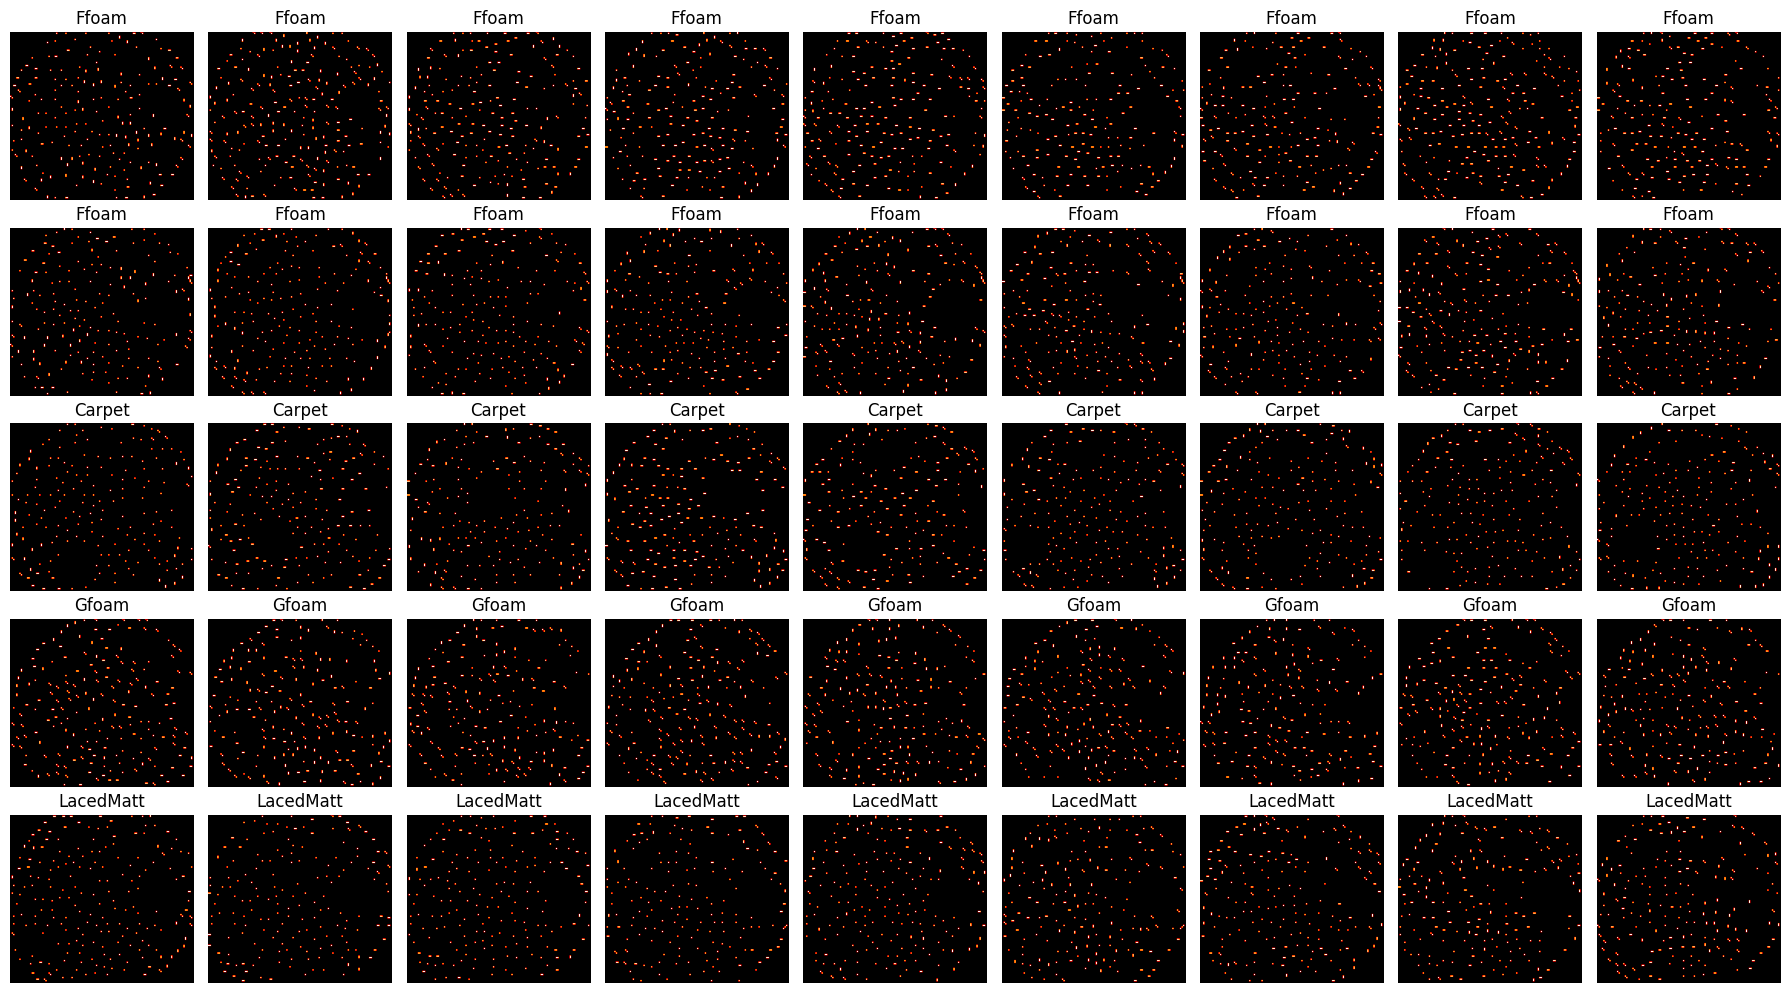

In [9]:
def plot_images_grid(images_grid,data):
    """
    Plots a grid of images, where each sublist in images_grid represents a row of images.
    
    Parameters:
    images_grid (list of lists): List of lists where each sublist contains images for a row.
    """
    num_rows = len(images_grid)
    num_cols = max(len(row) for row in images_grid)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    
    # Flatten axes if there's only one row or column for consistency
    if num_rows == 1:
        axes = [axes]
    if num_cols == 1:
        axes = [[ax] for ax in axes]
    c=0
    # Plot each image in the correct position
    for row_idx, row_images in enumerate(images_grid):
        for col_idx, img in enumerate(row_images):
            ax = axes[row_idx][col_idx]
            ax.set_title(data.keys[data.y[c]])
            ax.imshow(img, cmap='gist_heat' if img.ndim == 2 else None)
            ax.axis('off')  # Hide the axes for a cleaner look
        c+=1
    # Hide any unused subplots if the rows have different lengths
    for row_idx in range(num_rows):
        for col_idx in range(len(images_grid[row_idx]), num_cols):
            axes[row_idx][col_idx].axis('off')

    plt.tight_layout()
    plt.show()

plot_images_grid(flow_data_a[0:5],data)

## train network on this

In [16]:
n=-1
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(flow_y[0:n])
one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
x_data=flow_data_a[0:n].reshape((len(flow_data_a[0:n]),1,abs(flow_data_a.shape[1])*flow_data_a.shape[2],flow_data_a.shape[3]))
x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
del x_data
train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

# Create a TensorDataset
dataset = TensorDataset(train_images_tensor, train_labels_tensor)
# Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for training and testing sets
train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)
model,history=run(train_loader,0,4,num_epochs = 100)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodelcnn_optic_flow") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")

/tmp/ipykernel_1598864/836657166.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [480/480], Loss: 1117.2915
Epoch [11/100], Step [480/480], Loss: 0.4085
Epoch [21/100], Step [480/480], Loss: 0.1551
Epoch [31/100], Step [480/480], Loss: 0.0913


### lstm

In [37]:
n=-1
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(flow_y[0:n])
one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
x_data=flow_data_a[0:n].reshape((len(flow_data_a[0:n]),abs(flow_data_a.shape[1]),flow_data_a.shape[2]*flow_data_a.shape[3]))
#x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
x/=255
train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
del x_data
train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

# Create a TensorDataset
dataset = TensorDataset(train_images_tensor, train_labels_tensor)
# Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for training and testing sets
train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)
model,history=runLSTM(train_loader,0,10,num_epochs = 200)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodellstm_optic_flow") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")

/tmp/ipykernel_1594693/4159573806.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/200], Step [120/120], Loss: 324.6456
Epoch [11/200], Step [120/120], Loss: 318.7175
Epoch [21/200], Step [120/120], Loss: 292.4398
Epoch [31/200], Step [120/120], Loss: 218.4090
Epoch [41/200], Step [120/120], Loss: 157.8653
Epoch [51/200], Step [120/120], Loss: 91.5385
Epoch [61/200], Step [120/120], Loss: 40.7039
Epoch [71/200], Step [120/120], Loss: 14.5386
Epoch [81/200], Step [120/120], Loss: 6.3397
Epoch [91/200], Step [120/120], Loss: 3.7677
Epoch [101/200], Step [120/120], Loss: 2.5890
Epoch [111/200], Step [120/120], Loss: 1.9344
Epoch [121/200], Step [120/120], Loss: 1.5251
Epoch [131/200], Step [120/120], Loss: 1.2475
Epoch [141/200], Step [120/120], Loss: 1.0491
Epoch [151/200], Step [120/120], Loss: 0.9001
Epoch [161/200], Step [120/120], Loss: 0.7854
Epoch [171/200], Step [120/120], Loss: 0.6945
Epoch [181/200], Step [120/120], Loss: 0.6211
Epoch [191/200], Step [120/120], Loss: 0.5606
Finished Training
Accuracy: 98.82509790850763 %
0.9882509790850763
Accuracy: 9

In [10]:
n=-1
x_data=flow_data[0:n].reshape((len(flow_data[0:n]),abs(flow_data.shape[1]),flow_data.shape[2]*flow_data.shape[3]))
image=x_data[0][0]
model = SimpleLSTM(image.shape[0],350,15).to(device)#.half()
model.load_state_dict(torch.load(path+"/model/mymodellstm_optic_flow"))
model.eval()

/tmp/ipykernel_1598864/1168738564.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path+"/model/mymodellstm_optic_flow"))


RuntimeError: Error(s) in loading state_dict for SimpleLSTM:
	Unexpected key(s) in state_dict: "lstm.weight_ih_l1", "lstm.weight_hh_l1", "lstm.bias_ih_l1", "lstm.bias_hh_l1", "lstm.weight_ih_l2", "lstm.weight_hh_l2", "lstm.bias_ih_l2", "lstm.bias_hh_l2". 

In [12]:
n=-1
x_data=flow_data[0:n].reshape((len(flow_data[0:n]),1,abs(flow_data.shape[1])*flow_data.shape[2],flow_data.shape[3]))
image=x_data[0][0]
model = SimpleCNN(image.shape[0],image.shape[1],15).to(device)#.half()
model.load_state_dict(torch.load(path+"/model/mymodelcnn_optic_flow"))
model.eval()

/tmp/ipykernel_1598864/2210332082.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path+"/model/mymodelcnn_optic_flow"))


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=74100, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=15, bias=True)
  (relu): ReLU()
)

In [ ]:
sample=200
torch.cuda.empty_cache()
#x=torch.tensor(flow_data2.reshape((flow_data2.shape[0],flow_data2.shape[1],flow_data2.shape[2]*flow_data2.shape[3])), dtype=torch.float32).to(device) #lstm
x=torch.tensor(flow_data2.reshape((flow_data2.shape[0],1,flow_data2.shape[1]*flow_data2.shape[2],flow_data2.shape[3])), dtype=torch.float32).to(device) #cnn
x/=255
#x=(x-torch.mean(x))/(torch.max(x)-torch.min(x)) #preprocessing
preds=model(x[0:sample])
vals=torch.argmax(preds,axis=1).cpu().detach().numpy()
error=np.abs(vals-data2.y[0:sample])

print("Accuracy ",len(np.where(error==0)[0]),"/400",":",len(np.where(error==0)[0])/400 *100,"%")

Accuracy  13 /400 : 3.25 %


In [ ]:
torch.cuda.empty_cache()
sample=200
#x=torch.tensor(flow_data3.reshape((flow_data3.shape[0],flow_data3.shape[1],flow_data3.shape[2]*flow_data3.shape[3])), dtype=torch.float32).to(device) #lstm
x=torch.tensor(flow_data3.reshape((flow_data3.shape[0],1,flow_data3.shape[1]*flow_data3.shape[2],flow_data3.shape[3])), dtype=torch.float32).to(device) #cnn
x/=255
#x=(x-torch.mean(x))/(torch.max(x)-torch.min(x)) #preprocessing
preds=model(x[0:sample])
vals=torch.argmax(preds,axis=1).cpu().detach().numpy()
error=np.abs(vals-data3.y[0:sample])

print("Accuracy ",len(np.where(error==0)[0]),"/400",":",len(np.where(error==0)[0])/400 *100,"%")

Accuracy  23 /400 : 5.75 %
